# Notebook for Analyzing the Results of Search Experiments

checklist of data to collect for this: 
- 
- 
- 

## Basic Solve Rates


This graph just summarizes the macro level performance of the methods at a fixed budget.

In [3]:
import json
import matplotlib.pyplot as plt
from alphaarc.task import Task

In [4]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def compute_solve_rate(path): 
    with open(path) as f:
        data = json.load(f)
    solved = sum(1 for task in data if task['success'])
    return solved

def compute_table_data(methods, solved, total):
    rows = []
    for method, s in zip(methods, solved):
        s_int = int(s)
        rate = round((s_int / total) * 100, 1)
        rows.append({
            "Method": method,
            "Solved": s_int,
            "Total": total,
            "Solve Rate (%)": rate
        })
    return rows

# Compute solve results
mcts_results = compute_solve_rate('../results/mcts-2-0.2/experiment_results.json')
tg_mcts_results = compute_solve_rate('../results/tgmcts/experiment_results.json')
splint_mcts_results = compute_solve_rate('../results/splintmcts-4-0.2/experiment_results.json')

# Plotting
results = [mcts_results, tg_mcts_results, splint_mcts_results]
labels = ['MCTS', 'TG-MCTS', 'Splint-MCTS']
total = 89
table_rows = compute_table_data(labels, results, total)

for row in table_rows:
    print(row)

{'Method': 'MCTS', 'Solved': 0, 'Total': 89, 'Solve Rate (%)': 0.0}
{'Method': 'TG-MCTS', 'Solved': 5, 'Total': 89, 'Solve Rate (%)': 5.6}
{'Method': 'Splint-MCTS', 'Solved': 7, 'Total': 89, 'Solve Rate (%)': 7.9}


## Node Expansion Scalability

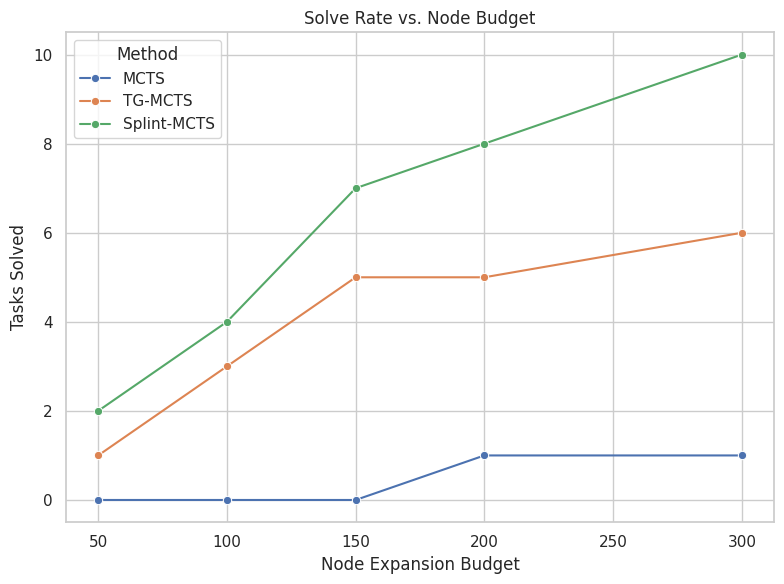

In [25]:

def node_expansion_plot(solve_rates, budgets): 
    # Convert to long-form DataFrame for seaborn
    data = []
    for method, rates in solve_rates.items():
        for budget, rate in zip(budgets, rates):
            data.append({"Method": method, "Node Budget": budget, "Solved Tasks": rate})

    df = pd.DataFrame(data)

    # Plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    ax = sns.lineplot(data=df, x="Node Budget", y="Solved Tasks", hue="Method", marker="o")

    ax.set_title("Solve Rate vs. Node Budget")
    ax.set_ylabel("Tasks Solved")
    ax.set_xlabel("Node Expansion Budget")
    ax.legend(title="Method")
    plt.tight_layout()
    plt.show()


budgets = [50, 100, 150, 200, 300]

solve_rates = {
    "MCTS":        [0, 0, 0, 1, 1],
    "TG-MCTS":     [1, 3, 5, 5, 6],
    "Splint-MCTS": [2, 4, 7, 8, 10],
}


node_expansion_plot(solve_rates, budgets)

## Overlapping Efficiency

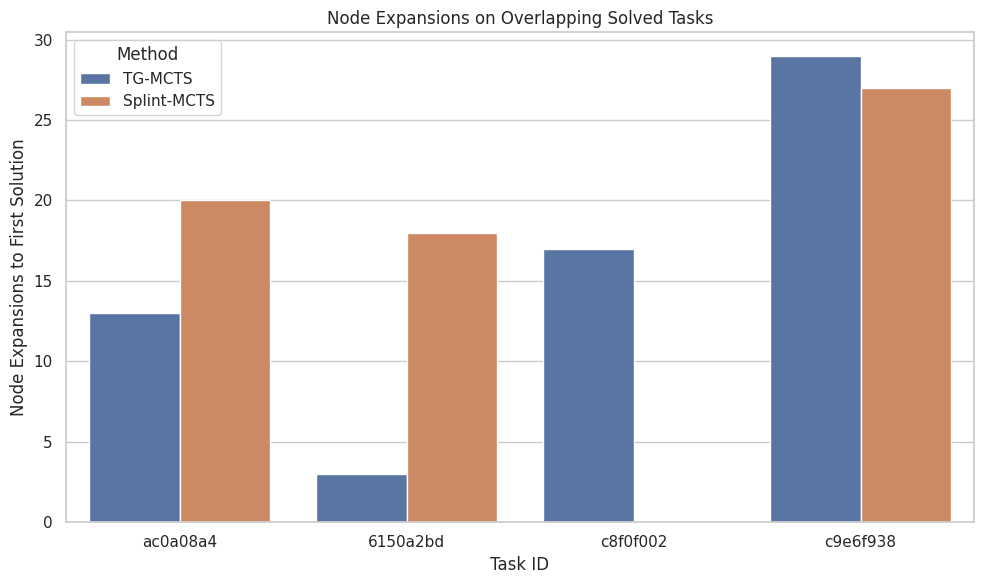

In [ ]:
# can actually do this now. 

def plot_overlapping_efficiency(overlap, tg_mcts_nodes, splint_mcts_nodes): 
    # Build DataFrame
    data = []
    for task in overlap:
        data.append({"Task": task, "Method": "TG-MCTS", "Nodes Used": tg_mcts_nodes[task]})
        data.append({"Task": task, "Method": "Splint-MCTS", "Nodes Used": splint_mcts_nodes[task]})

    df = pd.DataFrame(data)

    # Plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df, x="Task", y="Nodes Used", hue="Method")

    ax.set_title("Node Expansions on Overlapping Solved Tasks")
    ax.set_ylabel("Node Expansions to First Solution")
    ax.set_xlabel("Task ID")
    plt.legend(title="Method")
    plt.tight_layout()
    plt.show()



def find_solved_tasks(path):
    with open(path) as f:
        data = json.load(f)

    solved_tasks = {}


    for task in data:

        if task['success']:
            solved_tasks[task['task']] = task['extra']['nodes_expanded']


    return solved_tasks    

tg_mcts_results = find_solved_tasks('../results/tgmcts/experiment_results.json')
splint_mcts_results = find_solved_tasks('../results/splintmctsprior/experiment_results.json')
intersection = list(set(tg_mcts_results.keys()) & set(splint_mcts_results.keys()))


plot_overlapping_efficiency(intersection, tg_mcts_results, splint_mcts_results)

## Length of Tasks Solved

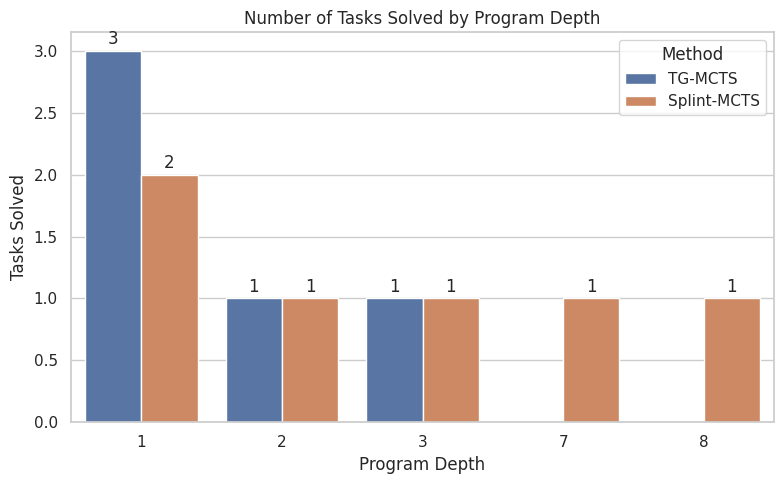

In [25]:
def find_solved_tasks(path):
    with open(path) as f:
        data = json.load(f)

    solved_tasks = []

    for task in data:

        if task['success']:
            solved_tasks.append(task['task'])
    return solved_tasks    


def compute_program_depths(): 
    with open('../data/split_keys.json') as fp:
        json_object = json.load(fp)

    validation_tasks = json_object['val']
    validation_tasks = [Task.from_json(f'../data/training/{x}.json') for x in validation_tasks]
    
    program_length_dict = {}

    for task in validation_tasks:
        program_length_dict[task.task_key] = len(task.program_lines.split("\n"))

    return program_length_dict


def plot_program_depths(program_depths, mcts_results, tg_mcts_results, splint_mcts_results): 
    # Build dataframe for plotting
    solved_by_real = {
        "MCTS": mcts_results,
        "TG-MCTS": tg_mcts_results,
        "Splint-MCTS": splint_mcts_results,
    }

    data_real = []
    for method, tasks in solved_by_real.items():
        for task in tasks:
            depth = program_depths.get(task)
            if depth is not None:
                data_real.append({"Method": method, "Depth": str(depth)})

    df_real = pd.DataFrame(data_real)

    # Plot grouped bar chart
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(data=df_real, x="Depth", hue="Method")

    # Add labels to bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', padding=2)

    plt.title("Number of Tasks Solved by Program Depth")
    plt.xlabel("Program Depth")
    plt.ylabel("Tasks Solved")
    plt.tight_layout()
    plt.show()

program_depths = compute_program_depths()
mcts_results = find_solved_tasks('../results/mcts-2-0.2/experiment_results.json')
tg_mcts_results = find_solved_tasks('../results/tgmcts/experiment_results.json')
splint_mcts_results = find_solved_tasks('../results/splintmctsprior/experiment_results.json')

plot_program_depths( program_depths, mcts_results, tg_mcts_results, splint_mcts_results)

## Failure Case Analysis